In [ ]:
import pandas as pd
data = pd.read_csv("logs.csv")

data['failure_flag'] = data['status'].apply(lambda x: 1 if x == 'failed' else 0)

data.head()


,timestamp,pipeline_id,stage_name,job_name,task_name,status,message,commit_id,branch,user,environment,failure_flag
0,2024-03-02 01:05:07+0000,pipe-txnem,Build,deploy_to_staging,analyze,success,Task completed successfully.,f831dbe56dcbceadccc1447923b1d9659becadbe,branch_ajn,NaN,NaN,0
1,2024-07-22 19:55:41+0000,pipe-hjahz,Build,run_unit_tests,deploy,skipped,Task was skipped due to pipeline conditions.,dcbac61f342d8b5ed473959be9edbeb1dfaca028,branch_tgn,user_psc,NaN,0
2,2024-03-01 23:03:43+0000,pipe-vcsbx,Analysis,deploy_to_dev,deploy,success,Task completed successfully.,fded3f1e6bcedb9fc338c14dfad3aa360bb6b50c,branch_lti,user_usq,NaN,0
3,2024-06-02 12:21:00+0000,pipe-pnvzk,Test,deploy_to_dev,test,skipped,Task was skipped due to pipeline conditions.,2c9d4fbd41bb1c5c7feb06035d3b4feaf1ac45d0,branch_ezx,NaN,NaN,0
4,2024-04-17 07:59:29+0000,pipe-mwkkl,Test,build_and_test,test,failed,Task execution failed.,a4e872fbdf81f1d1742bf5ae0c76ee9d10eea02a,branch_xqp,user_umu,NaN,1


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['stage_encoded'] = encoder.fit_transform(data['stage_name'].astype(str))
data['task_encoded'] = encoder.fit_transform(data['task_name'].astype(str))
data['job_encoded'] = encoder.fit_transform(data['job_name'].astype(str))
data['branch_encoded'] = encoder.fit_transform(data['branch'].astype(str))
data['user_encoded'] = encoder.fit_transform(data['user'].astype(str))

user_failure_counts = data.groupby('user')['failure_flag'].cumsum() - data['failure_flag']
data['user_past_failures'] = user_failure_counts.fillna(0)

data['build_hour'] = pd.to_datetime(data['timestamp']).dt.hour

features = ['stage_encoded', 'task_encoded', 'job_encoded', 'branch_encoded',
            'user_encoded', 'user_past_failures', 'build_hour']

X = data[features]
y = data['failure_flag']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=63)

model = RandomForestClassifier(n_estimators=100, random_state=37)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Report:\n", classification_report(y_test, y_pred))


Report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83       180
           1       0.08      0.02      0.03        60

    accuracy                           0.71       240
   macro avg       0.41      0.48      0.43       240
weighted avg       0.58      0.71      0.63       240



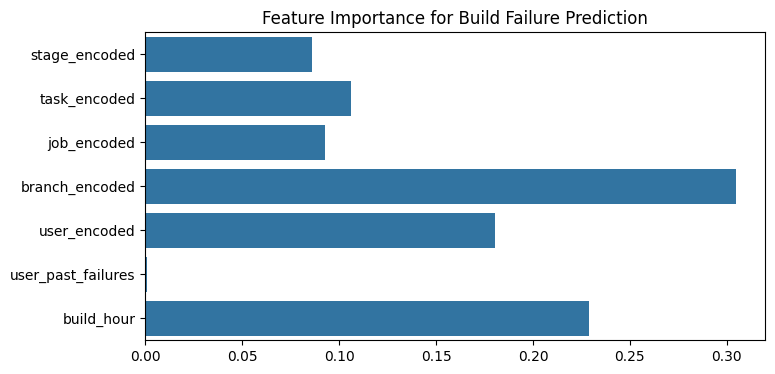

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(x=model.feature_importances_, y=features)
plt.title("Feature Importance for Build Failure Prediction")
plt.show()


In [ ]:
def recommendations(row):
    actions = []
    if row['stage_name'] == 'Test':
        actions.append("Investigate failing test cases and ensure test stability")
    if row['task_name'] == 'deploy' and row['failure_flag'] == 1:
        actions.append("Verify scripts and environment variables.")
    if row['user_past_failures'] > 3:
        actions.append("Request tp review code before next commit.")
    return actions or ["No actions needed."]

data['Failure_Pred'] = model.predict(X)
data['Recommendation'] = data.apply(recommendations, axis=1)

output = data[['pipeline_id', 'stage_name', 'job_name', 'task_name', 'status', 'failure_flag',
             'Failure_Pred', 'Recommendation']]

output.head(10)


,pipeline_id,stage_name,job_name,task_name,status,failure_flag,Failure_Pred,Recommendation
0,pipe-txnem,Build,deploy_to_staging,analyze,success,0,0,[No actions needed.]
1,pipe-hjahz,Build,run_unit_tests,deploy,skipped,0,0,[No actions needed.]
2,pipe-vcsbx,Analysis,deploy_to_dev,deploy,success,0,0,[No actions needed.]
3,pipe-pnvzk,Test,deploy_to_dev,test,skipped,0,0,[Investigate failing test cases and ensure tes...
4,pipe-mwkkl,Test,build_and_test,test,failed,1,0,[Investigate failing test cases and ensure tes...
5,pipe-bcxxl,Analysis,deploy_to_dev,deploy,success,0,0,[No actions needed.]
6,pipe-keewh,Test,build_and_test,test,failed,1,1,[Investigate failing test cases and ensure tes...
7,pipe-pocpk,Analysis,run_integration_tests,analyze,failed,1,0,[No actions needed.]
8,pipe-oredz,Build,run_unit_tests,deploy,skipped,0,0,[No actions needed.]
9,pipe-fzeaz,Test,deploy_to_dev,deploy,skipped,0,0,[Investigate failing test cases and ensure tes...
